<img src="https://th.bing.com/th/id/OIP.OK7hmi6u15vBgpgj2_BOmAHaE8?pid=ImgDet&rs=1" alt="image info" width="100" height="200"/> </div>


<span style="font-size: 3em">
        <span style="font-family:Yu Gothic UI Regular">
        Welcome! My name is Harry and this notebook will provide a walkthrough to access all of your songs from your Liked Playlist in Spotify.
    </span> 

____________________________
____________________________
<div class="alert alert-block alert-info">
<b>Part 1:</b> Let's explore the Spotify API and it's documentation. This research will teach us how to connect to the Spotify API and it will provide examples of code to get us started.
</div>
<div class="alert alert-block alert-warning">
<b>Part 2:</b> How do we access ALL of the songs in our playlists, the audio features of each song and finally should we use pure JSON or Pandas?
</div>
<div class="alert alert-block alert-success">
<b>Part 3:</b> Let's do some analysis!
</div>



-------------
-------------

<div class="alert alert-block alert-info">
<b>Part 1:</b> 
    Credentials needed to access the Spotify API
</div>

<span style="font-family:Yu Gothic UI Regular"> (1.a) Our first port of call is to go to https://developer.spotify.com/dashboard to access the info below. Make sure to create an app! </span>
<blockquote>
<p> 1. Client ID</p>
<p> 2. Client Secret</p>
</blockquote>

<span style="font-family:Yu Gothic UI Regular">Once you have the ClientId and Client Secret we can request an Access Token</span>
<blockquote>
<p> <b>Definition of Access Token:</b> </p>
<blockquote>
<p> The access token allows you to make requests to the Spotify Web API. To do so, you need to include the following header in your API calls:</p>
</blockquote>
</blockquote>

-------------------------------
<span style="font-family:Yu Gothic UI Regular"><b>Here's a nice flow chart showing the interactions of each component</b></span>
    
<img src="https://developer.spotify.com/assets/AuthG_ClientCredentials.png" alt="image info" width="500" height="1000"/>

---------------------------------

<span style="font-family:Yu Gothic UI Regular">(1.b) Next we head over to https://developer.spotify.com/console/get-current-user-saved-tracks/?market=ES&limit=50&offset=0</span>
<blockquote>
<p> This is where we will learn how to access for Spotify track information using GET requests</p>
</blockquote>

<span style="font-family:Yu Gothic UI Regular">Where should we focus our attention?</span>
<blockquote>
<p>The endpoint we are interested in is "https://api.spotify.com/v1/me/tracks"</p>
<blockquote>
<p> More specifically the parameters we pass to this endpoint "https://api.spotify.com/v1/me/tracks?<mark>market=ES</mark>&<mark>limit=50</mark>&<mark>offset=0</mark>"<p>
</blockquote>
<blockquote>
<p> We can only access 50 songs each request (limit = 50).</p>
<p> In order to control which 50 songs we use the offset param (offset = 0).</p>
<p> My playlist contains ~950 songs so we will need to make more than one request. For example...</p>
<blockquote>
<p> https://api.spotify.com/v1/me/tracks?market=ES&limit=50&<mark>offset=0</mark> <p>
<p> https://api.spotify.com/v1/me/tracks?market=ES&limit=50&<mark>offset=50</mark> <p>
<p> https://api.spotify.com/v1/me/tracks?market=ES&limit=50&<mark>offset=100</mark> <p>    
</blockquote>
</blockquote>
</blockquote>

-----------------
# Let's start
-----------------

In [1]:
import requests
import json
import pandas as pd
import numpy as np
from lookup import *

%load_ext autoreload
%autoreload 2

-----------------
### For the first part, we will copy and paste the OAuth Token (from link below) and use this as our Access Token.
https://developer.spotify.com/console/get-current-user-saved-tracks/?market=ES&limit=50&offset=0

-----------------

In [ ]:

# Define our URL 
url = 'https://api.spotify.com/v1/me/tracks?limit=50&offset=0'

# Copy and paste from link 
access_token = ACCESS_TOKEN_SCOPED

# Set up the header required for the GET request
headers = {"Authorization":f"Bearer {access_token}"
          }
# Use the request library to make a get request using the header
r = requests.get(url=url,headers=headers)
r_json1 = r.json()
r_json1

-----------------

### (↑) This request returns a JSON object containing the first 50 songs in my playlist.
### Now we need to create a loop that returns each chunk of 50 songs. Let's create an empty dataframe to save the results. Use a sleep function so we don't bombard the Spotify API and get into trouble

-----------------

In [ ]:
# time module used for sleep function
import time

# Define the header
headers = {"Authorization":f"Bearer {access_token}"
          }

# Define the access token
access_token = ACCESS_TOKEN_SCOPED

# Create a list of intervals of 50 for each request
offset_value_list = np.arange(0,1050,50)

# Create an empty dataframe
outputCombined = pd.DataFrame()

## Test URL print output
for i in offset_value_list:
    # Use an f-string to reformat the url each iteration 
    url = f'https://api.spotify.com/v1/me/tracks?limit=50&offset={i}'
    r = requests.get(url=url,headers=headers)
    r_json = r.json()
    
    # Convert the dictionary into a pandas dataframe and save the results as csvs
    pd.DataFrame.from_dict(r_json).to_csv(f'output/liked_playlist_offset_{i}.csv')
    
    # Sleep 5 seconds
    time.sleep(5)

<div class="alert alert-block alert-warning">
<b>Part 2:</b> 
    Combined our results, clean the dataset and add audio features to each track
</div>

---------------------
<span style="font-family:Yu Gothic UI Regular">(2a) Let's combine the csv files togther</span>
<blockquote>
<p>  Use 'os' list dir to gather all the files we need together. We need to focus on files with '.csv' suffix</p>
</blockquote>

---------------------

In [ ]:
import os 

# Create an empty dataframe
combinedCsvOutput = pd.DataFrame()

# Use 'os' and 'endswith' to quickly find the csvs, load them and concatenate them
for i in os.listdir('output'):
    if i.endswith('.csv'):
        a = pd.read_csv(f'output/{i}',index_col=0)
        combinedCsvOutput = pd.concat([combinedCsvOutput,a],axis=0,ignore_index=True)

# Let's save our results
combinedCsvOutput.to_csv('output/combined/output_csv_combined.csv')

---------------------

<span style="font-family:Yu Gothic UI Regular">(2b) Let's reload the data and name it dfMyPlaylist and use a safe string literal eval to begin accessing the JSON data</span>
<blockquote>
<p> dfMyPlaylist - Each row is a song, and 'items' contains a dictionary of information related to the song. The dictionary can pose us some problems but it can also be a powerful way to save detailed data features in a single cell for each song</p>
</blockquote>
<blockquote>
<p> We need to <mark>Convert a String Representation of a Dictionary</mark> into a <b>Dictionary</b></p>
<blockquote>
<p> We can achieve this by using <b>ast.literal_eval method </b> </p>
<p> The ast.literal_eval method can <mark>safely</mark> evaluate strings containing Python values from unknown sources without us having to parse the values. However, complex expressions involving indexing or operators cannot be evaluated using this function. </p>
<p> Let's use the ast.literal_eval_method to reestablish the correct datatype for accessing the <b>lambda functions</b> </p>
</blockquote>
</blockquote>

---------------------

In [2]:
import ast
# help(ast.literal_eval)

# Loading the data from csvs distrupts the data types. As a result we cannot access the dictionaries using lambda functions straight away.
dfMyPlaylist = pd.read_csv('output/combined/output_csv_combined.csv',index_col=0)

# Let's convert items into a accessible dictionary using  ast.literal_eval
dfMyPlaylist['items'] = dfMyPlaylist.apply(lambda x: ast.literal_eval(x['items']),axis=1)

---------------------

<span style="font-family:Yu Gothic UI Regular">JSON data can be a little tricky to breakdown sometimes so let's use pretty print (pprint) to make things easier</span>
<blockquote>
<p>  We can begin mapping our path to information we are interested in and then use lambda functions to parse it out</p>
</blockquote>

---------------------

In [3]:
from pprint import pprint

viewJson = dfMyPlaylist.apply(lambda x: x['items']['track']['album']['artists'][0]['id'],axis=1)[0]
pprint(viewJson,indent=4,compact=True)

'465IoLV7sBVtMQ3WJ756BL'


---------------------
# Next

<span style="font-family:Yu Gothic UI Regular">(2c) Below are the routes through the dictionary to identify information we are interested in.</span>
<blockquote>
<p>  We can begin mapping our path to information we are interested in and then use lambda functions to parse it out</p>
</blockquote>

<blockquote>
<p>  Left of equal sign is the name assignment and to the right we have our paths to the information using Lambda functions</p>
</blockquote>

---------------------

In [4]:
dfMyPlaylist['album_name'] = dfMyPlaylist.apply(lambda x: x['items']['track']['album']['name'],axis=1)
dfMyPlaylist['album_id'] = dfMyPlaylist.apply(lambda x: x['items']['track']['album']['id'],axis=1)
dfMyPlaylist['album_total_tracks'] = dfMyPlaylist.apply(lambda x: x['items']['track']['album']['total_tracks'],axis=1)
dfMyPlaylist['album_release_date'] = dfMyPlaylist.apply(lambda x: x['items']['track']['album']['release_date'],axis=1)

dfMyPlaylist['track_name'] = dfMyPlaylist.apply(lambda x: x['items']['track']['name'],axis=1)
dfMyPlaylist['track_id'] = dfMyPlaylist.apply(lambda x: x['items']['track']['id'],axis=1)
dfMyPlaylist['track_number'] = dfMyPlaylist.apply(lambda x: x['items']['track']['track_number'],axis=1)
dfMyPlaylist['track_popularity'] = dfMyPlaylist.apply(lambda x: x['items']['track']['track_number'],axis=1)

dfMyPlaylist['album_image_size_1'] = dfMyPlaylist.apply(lambda x: x['items']['track']['album']['images'][0]['url'],axis=1)
dfMyPlaylist['album_image_size_2'] = dfMyPlaylist.apply(lambda x: x['items']['track']['album']['images'][1]['url'],axis=1)
dfMyPlaylist['album_image_size_3'] = dfMyPlaylist.apply(lambda x: x['items']['track']['album']['images'][2]['url'],axis=1)

dfMyPlaylist['track_popularity'] = dfMyPlaylist.apply(lambda x: x['items']['track']['popularity'],axis=1)
dfMyPlaylist['track_added_playlist'] = dfMyPlaylist.apply(lambda x: x['items']['added_at'],axis=1)

dfMyPlaylist['track_preview_url'] = dfMyPlaylist.apply(lambda x: x['items']['track']['preview_url'],axis=1)


---------------------

<span style="font-family:Yu Gothic UI Regular">(2d) Now we want to get the audio features of each song</span>
<blockquote>
<p> This does not require us to authenticate us as users of specific spotify account</p>
<p> We can simply query the API without any scope and use our CLIENT_ID and CLIENT_SECRET</p>
<p> In this way we can refresh our access tokens and we don't need to copy and paste a scoped access token</p>    
</blockquote>

---------------------

In [ ]:
BASE_URL = 'https://api.spotify.com/v1'

AUTH_URL = 'https://accounts.spotify.com/api/token'

# POST
auth_response = requests.post(AUTH_URL, {
    'grant_type': 'client_credentials',
    'client_id': CLIENT_ID,
    'client_secret': CLIENT_SECRET,
})

# convert the response to JSON
auth_response_data = auth_response.json()

# save the access token
access_token = auth_response_data['access_token']

headers = {'Authorization': 'Bearer {token}'.format(token=access_token)
          }

---------------------
### Let's gather all the track_ids in to a list so we can pass it through the audio-features endpoint
---------------------

In [ ]:
track ids with audio features
trackIds = dfMyPlaylist['track_id'].to_list()

listTrackIds = trackIds
trackAudioFeaturesCombined = pd.DataFrame()


# Songs Audio Features
for i in listTrackIds:
    time.sleep(2)
    f = requests.get(f'{BASE_URL}/audio-features/{i}',headers=headers
                    )
    f = f.json()
    f = f.items()
    
    # Reshape vertical Series to horizontal dataframe
    df = pd.DataFrame.from_dict(f).transpose()
    
    #set column names equal to values in row index position 0
    df.columns = df.iloc[0]
    
    #remove first row from DataFrame
    df = df[1:]
    
    #concat updated DataFrame
    trackAudioFeaturesCombined = pd.concat([trackAudioFeaturesCombined,df],axis=0)
    
trackAudioFeaturesCombined.reset_index(drop=True,inplace=True)
trackAudioFeaturesCombined.to_csv('output/combined/track_audio_features_final(v2).csv')

-----------------
### Join the Audio Features to my track dataframe

-----------------

In [5]:
dfAudioFeatures = pd.read_csv('output/combined/track_audio_features_final.csv',index_col=0)
dfAudioFeatures.rename(columns={'id':'track_id'},inplace=True)

In [6]:
dfMyPlaylistAudioFeatures = pd.merge(dfMyPlaylist,dfAudioFeatures,on='track_id',suffixes=('_playlist','_audiofeatures'))

<div class="alert alert-block alert-success">
<b>Part 3:</b> Let's do some analysis!
</div>

-----------------
<span style="font-family:Yu Gothic UI Regular">(3a) Let's break the analysis down:</span>
<blockquote>
    <p> <b>i)</b> Exploratory Data Analysis </p>
    <p> <b>ii)</b> </p>
    <p> <b>iii)</b> </p>   
</blockquote>

-----------------

# 3.a.i)

In [8]:
dfMyPlaylistAudioFeatures['track_added_playlist'] = pd.to_datetime(dfMyPlaylistAudioFeatures['track_added_playlist'])

In [9]:
dfMyPlaylistAudioFeatures['track_added_playlist_year'] = dfMyPlaylistAudioFeatures['track_added_playlist'].dt.year
dfMyPlaylistAudioFeatures['track_added_playlist_month'] = dfMyPlaylistAudioFeatures['track_added_playlist'].dt.month

In [120]:
dfMyPlaylistAudioFeatures.columns

Index(['href', 'items', 'limit', 'next', 'offset', 'previous', 'total',
       'album_name', 'album_id', 'album_total_tracks', 'album_release_date',
       'track_name', 'track_id', 'track_number', 'track_popularity',
       'album_image_size_1', 'album_image_size_2', 'album_image_size_3',
       'track_added_playlist', 'track_preview_url', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'type', 'uri',
       'track_href', 'analysis_url', 'duration_ms', 'time_signature',
       'track_added_playlist_year', 'track_added_playlist_month'],
      dtype='object')

In [124]:
dfMyPlaylistAudioFeatures['album_release_year'] = pd.to_datetime(dfMyPlaylistAudioFeatures['album_release_date']).dt.year

In [139]:
numberOfTracksByYearMonth = dfMyPlaylistAudioFeatures.groupby(['track_added_playlist_year','track_added_playlist_month'])['track_id'].count().reset_index(name='tracks_per_month')

In [141]:
cumsum = numberOfTracksByYearMonth.groupby(["track_added_playlist_year"])['tracks_per_month'].cumsum().reset_index(name='cumulative_sum').drop('index',axis=1)

numberOfTracksByYearMonth = pd.merge(numberOfTracksByYearMonth,cumsum,left_index=True,right_index=True)

In [137]:
import seaborn as sns
import matplotlib.pyplot as plt

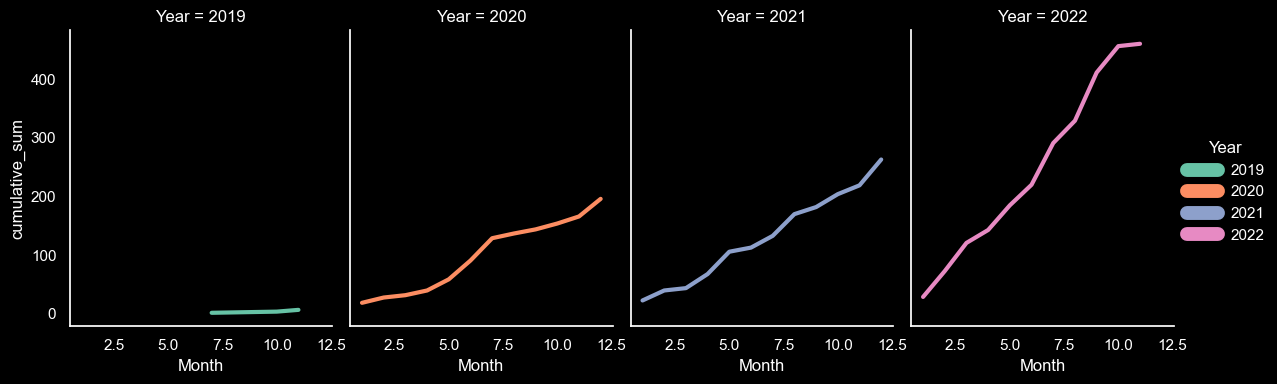

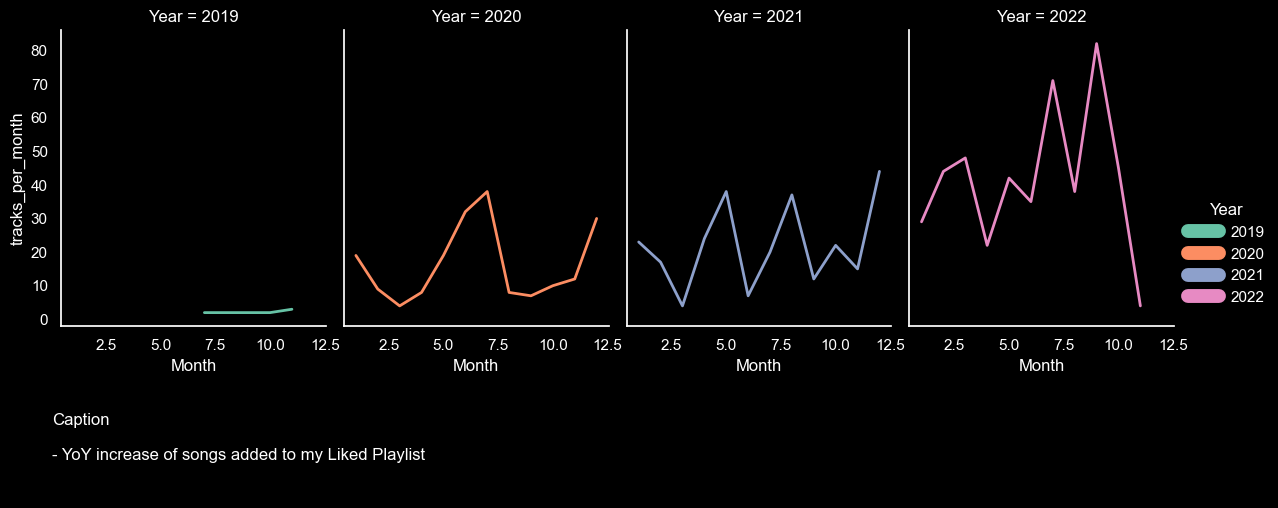

In [147]:
sns.set(rc={"axes.facecolor":"#000000", 
            "figure.facecolor":"#000000",
            "grid.color":"#000000",
            "text.color":"#ffffff",
            "xtick.color":'#ffffff',
            "ytick.color":'#ffffff',
            "axes.labelcolor":'#ffffff',
            "lines.linewidth":'10'})

g = sns.relplot(
    data=numberOfTracksByYearMonth.rename(columns={"track_added_playlist_year":"Year","track_added_playlist_month":"Month"}),
    x="Month", y="cumulative_sum", col="Year", hue="Year",
    kind="line", palette="Set2", linewidth=3,
    col_wrap=4, height=4, aspect=0.75, legend=True
)
sns.set(rc={"axes.facecolor":"#000000", 
            "figure.facecolor":"#000000",
            "grid.color":"#000000",
            "text.color":"#ffffff",
            "xtick.color":'#ffffff',
            "ytick.color":'#ffffff',
            "axes.labelcolor":'#ffffff',
            "lines.linewidth":'10'})

g = sns.relplot(
    data=numberOfTracksByYearMonth.rename(columns={"track_added_playlist_year":"Year","track_added_playlist_month":"Month"}),
    x="Month", y="tracks_per_month", col="Year", hue="Year",
    kind="line", palette="Set2", linewidth=2, zorder=3,
    col_wrap=4, height=4, aspect=0.75, legend=True
)

title = g.fig.suptitle(
'''
Caption\n
- YoY increase of songs added to my Liked Playlist\n
''',
y=-0.01,x=0.05,size=12,horizontalalignment='left')